# Plotting Running the nonadiabatic molecular dynamics (NA-MD)

In this tutorial, we perform NA-MD using the NACs computed in [step3](../../8_step3_cp2k/2_xTB). After the dynamic is done, we will fit the data using a stretched-compressed exponential function. We only do the dynamics for the NACs computed for the system in the xTB framework. The reason is that doing the NA-MD for the other system we considered with DFT, the rutile-$TiO_2$ unit cell, is exactly the same as below and you just need to modify some parameters as is explained in the [README.md](README.md) file. 

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Defining the functions and variables](#def_fun_var)
4. [Run the dynamics](#run_dyn) 
5. [Decoherence times](#deco_times)
6. [Fitting data](#fit_data)

### A. Learning objectives

* To be able to run the NA-MD using Libra
* To be able to compute the decoherence times
* To be able to compute the average NA-MD timescales

### B. Use cases

* [Run the dynamics](#run_dyn)
* [Decoherence times](#deco_times)
* [Fitting data](#fit_data)


### C. Functions

- `libra_py`
  - `data_conv`
  - `data_stat`
  - `data_outs`
  - `data_read`
  - `workflows`
    - `nbra`
      - [`step4`](#run_dyn)
        - [`namd_workflow`](#run_dyn)
      - [`decoherence_times`](#deco_times)
        - [`decoherence_times`](#deco_times)
  - `units`
    - `fs2au`
    


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library to read them. Import `numpy`, `scipy.sparse`, `data_conv`, `data_outs`, `data_stat`, `data_io`, `units`, and `step4` modules and also the `ann` for doing the NA-MD using artificial neural netwrok (we do not cover this in here). Also, `multiprocessing` library will be needed to simultaneously run the NA-MD in different batches.
The `scipy.optimize.curve_fit` will be used to fit the data and plot them using `matplotlib`.

In [1]:
import os
import sys
import math
import time
import glob 

import multiprocessing as mp
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

from liblibra_core import *
import util.libutil as comn
from libra_py import units as units
from libra_py import data_conv, data_stat, data_outs, data_read
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.workflows.nbra.step4 as step4
import libra_py.workflows.nbra.ann as ann

/home/98722002/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/98722002/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/98722002/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float,

## average_decoherence_sd

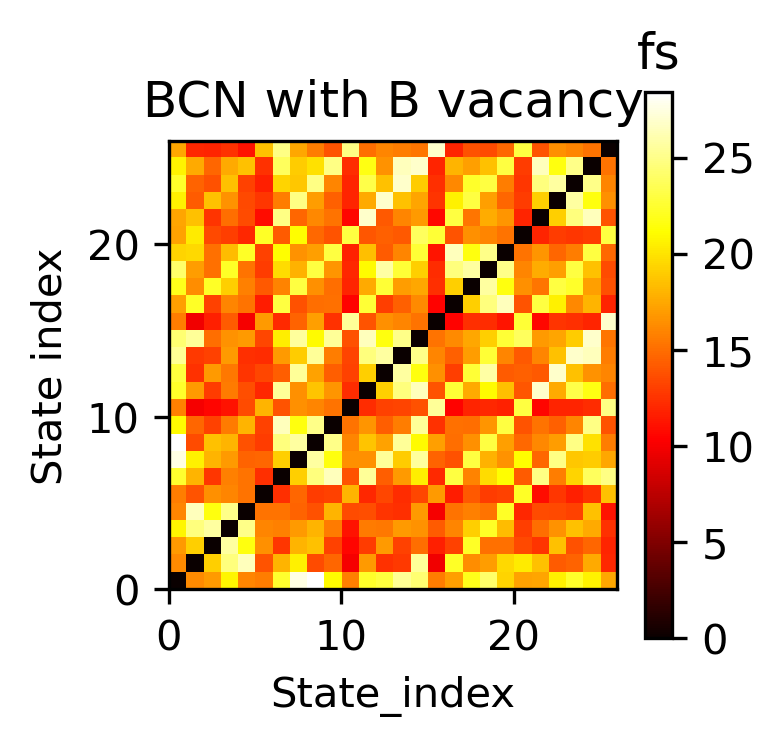

In [2]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(2.41, 2.41), dpi=300, edgecolor='black', frameon=True)        

avg_deco = np.loadtxt('./results/average_decoherence_sd.txt')
plt.imshow(np.flipud(avg_deco), extent=(0,avg_deco.shape[0],0,avg_deco.shape[1]), cmap='hot')
plt.colorbar().ax.set_title('fs')
plt.title('BCN with B vacancy')
plt.xlabel('State_index')
plt.ylabel('State index')
plt.savefig('./results/average_decoherence_sd.png', dpi=600)


## average_decoherence_mb-Hvib_sd

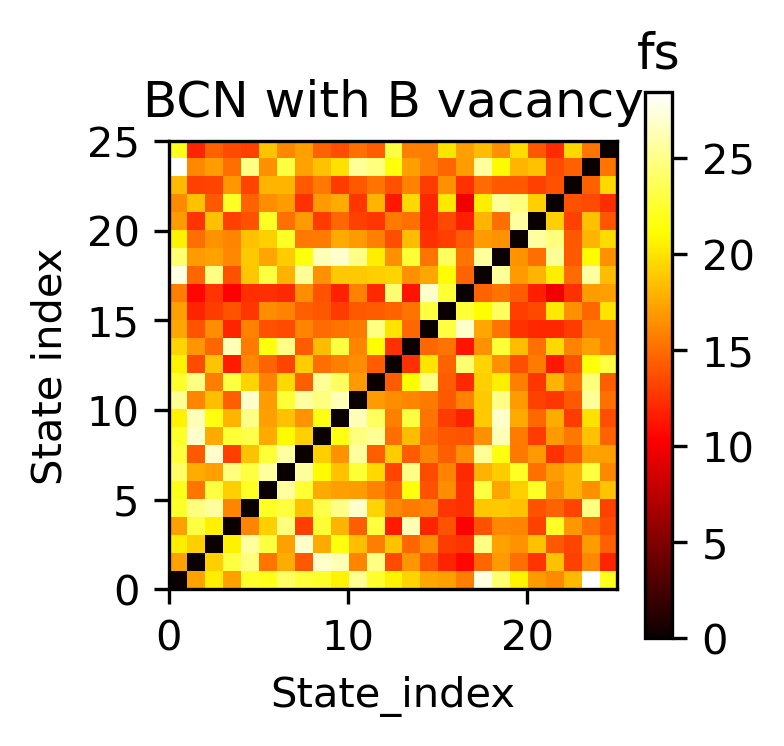

In [3]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(2.41, 2.41), dpi=300, edgecolor='black', frameon=True)        

avg_deco = np.loadtxt('./results/average_decoherence_mb-Hvib_sd.txt')
plt.imshow(np.flipud(avg_deco), extent=(0,avg_deco.shape[0],0,avg_deco.shape[1]), cmap='hot')
plt.colorbar().ax.set_title('fs')
plt.title('BCN with B vacancy')
plt.xlabel('State_index')
plt.ylabel('State index')
plt.savefig('./results/average_decoherence_mb.png', dpi=600)


## average_decoherence_mb-Hvib_ci

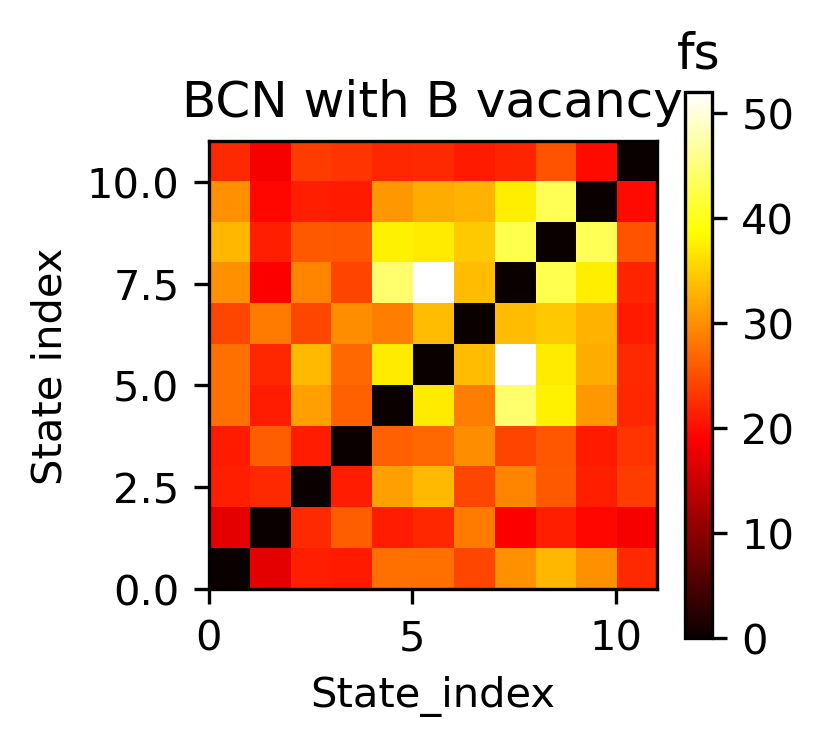

In [4]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(2.41, 2.41), dpi=300, edgecolor='black', frameon=True)        

avg_deco = np.loadtxt('./results/average_decoherence_mb-Hvib_ci.txt')
plt.imshow(np.flipud(avg_deco), extent=(0,avg_deco.shape[0],0,avg_deco.shape[1]), cmap='hot')
plt.colorbar().ax.set_title('fs')
plt.title('BCN with B vacancy')
plt.xlabel('State_index')
plt.ylabel('State index')
plt.savefig('./results/average_decoherence_mb.png', dpi=600)


## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

The only files that we need are the NACs obtained in [this tutorial](../../8_step3_cp2k/2_xTB/res-mixed-basis).

The `inputs.tar.bz2` archive is the `data.tar.bz2` archive from that tutorial. 

We only need to unpack it:

    tar -xjf inputs.tar.bz2

## 3. Defining the functions and variables <a name="def_fun_var"></a>
[Back to TOC](#toc)

The helper functions are used in here. We will set the parameters in here. The list of all parameters are completely explained in the [README.md](README.md) file.

## 5. Decoherence times <a name="deco_times"></a>
[Back to TOC](#toc)

We have computed the average decoherence times between pairs of states when we ran the dynamics in the last cell in `average_decoherence.txt` file. Now, we load and plot it using `plt.imshow`.

## 6. Fitting data <a name="fit_data"></a>
[Back to TOC](#toc)


After the dynamic is done, we load all the NA-MD results, stored in `SH_pop.txt` files, using `np.loadtxt` and start fitting them to a stretched-compressed exponential function of the form:

$$P(t; E_0)=\exp(-(\frac{t}{\tau})^\beta)$$


Then, the average time scale is computed for the fits that has an $R^2$ value more than $0.01$. The error bars are computed using the following formula:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $s$ is the stadard deviaton and $N$ is the number of samples (the ones that have $R^2$ value of more than $0.01$). The $Z$ value is the confidence interval coefficient which for confidence interval of $95\%$, a value of $1.96$ is chosen.

In the above, we have only considered, FSSH and IDA ad for simplicity, we will consider the decay dynamics of the hot state which is the 10th state. Also, please note that this is just an example and we want to show how the workflow is. So, we consider even lower $R^2$ value. For better and more accurate results, we need not only longer trajectory but also larger number of surface hopping trajectory.

------------FSSH----------
Folder = ./results/namd_regular_sd/_start_s10_FSSH_batch0
tau: 130.399937080341  beta: 1.0576872759250295  R2: 0.9729843123769608
Folder = ./results/namd_regular_sd/_start_s10_FSSH_batch1
tau: 134.7914486206008  beta: 1.2073304047151623  R2: 0.9876986377765136
Folder = ./results/namd_regular_sd/_start_s10_FSSH_batch2
tau: 135.90765138246778  beta: 1.6211958427920774  R2: 0.9880376096443719
Folder = ./results/namd_regular_sd/_start_s10_FSSH_batch3
tau: 196.28776947589824  beta: 1.2411691779773828  R2: 0.9877827370503631
Folder = ./results/namd_regular_sd/_start_s10_FSSH_batch4
tau: 137.93698024025716  beta: 1.2398845547324955  R2: 0.9866165525626208
Folder = ./results/namd_regular_sd/_start_s10_FSSH_batch5
tau: 144.33789699661634  beta: 0.8776024636799302  R2: 0.9680882707132608
Folder = ./results/namd_regular_sd/_start_s10_FSSH_batch6
tau: 136.79814535405959  beta: 0.9817381912570499  R2: 0.9462149207777568
Folder = ./results/namd_regular_sd/_start_s10_FSSH_b

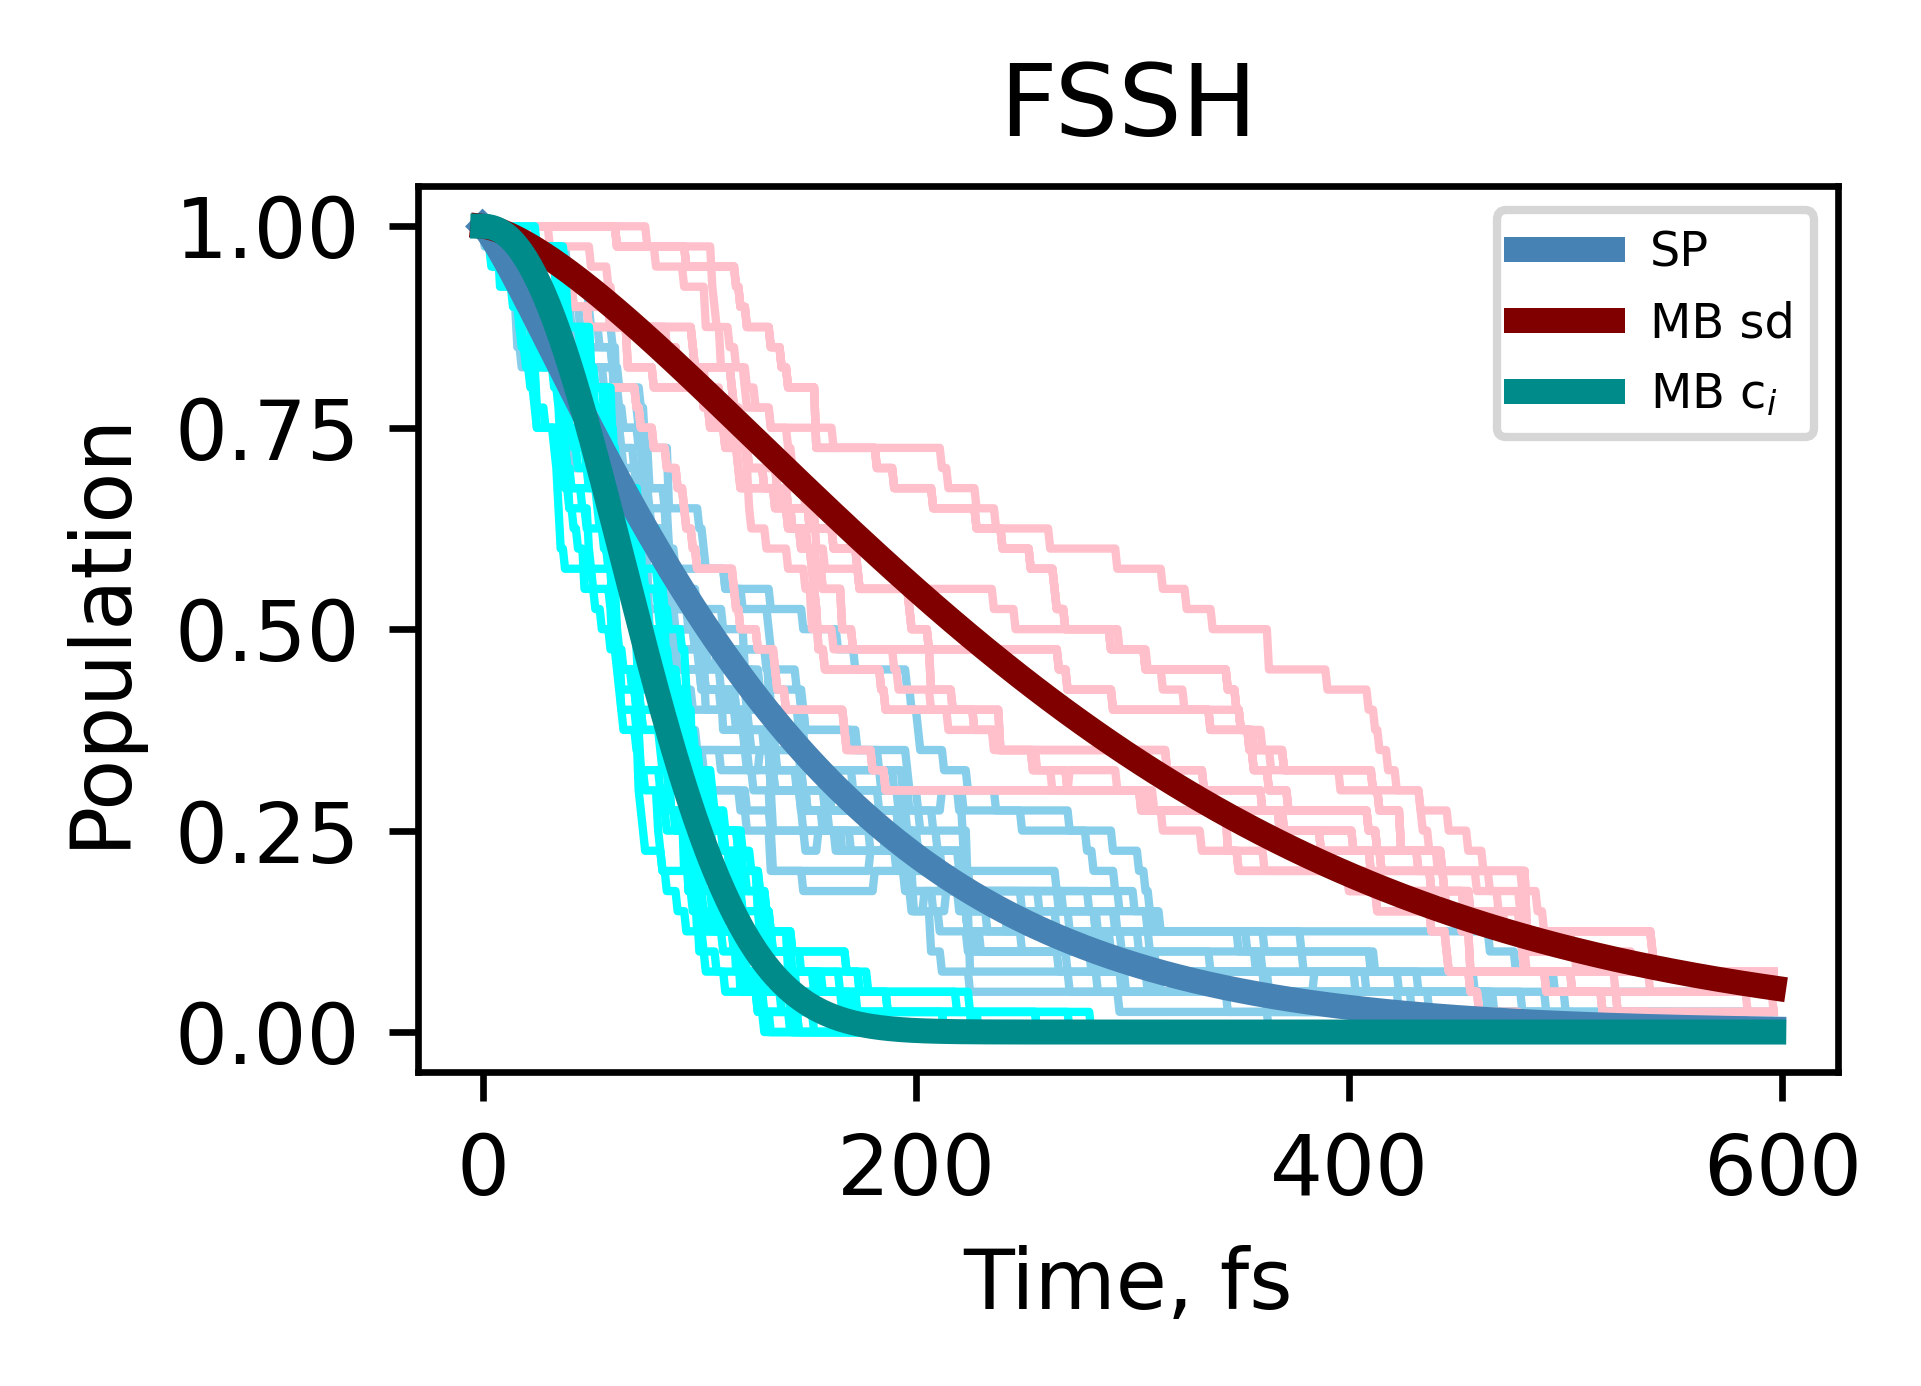

------------IDA----------
Folder = ./results/namd_regular_sd/_start_s10_IDA_batch0
tau: 175.88400938020408  beta: 1.215345723816199  R2: 0.9944640993678587
Folder = ./results/namd_regular_sd/_start_s10_IDA_batch1
tau: 131.57537535895332  beta: 1.1071526965917513  R2: 0.9747274834704869
Folder = ./results/namd_regular_sd/_start_s10_IDA_batch2
tau: 152.68868963297462  beta: 1.0317063888760123  R2: 0.9593180255846157
Folder = ./results/namd_regular_sd/_start_s10_IDA_batch3
tau: 148.70706294547912  beta: 1.4238214875131439  R2: 0.9954095070451559
Folder = ./results/namd_regular_sd/_start_s10_IDA_batch4
tau: 132.83848234538897  beta: 1.1614067081415589  R2: 0.9865277536334223
Folder = ./results/namd_regular_sd/_start_s10_IDA_batch5
tau: 145.39126290559133  beta: 1.121663518802162  R2: 0.9754334539074816
Folder = ./results/namd_regular_sd/_start_s10_IDA_batch6
tau: 141.19846530202713  beta: 0.9545250827101087  R2: 0.970242545078301
Folder = ./results/namd_regular_sd/_start_s10_IDA_batch7
tau

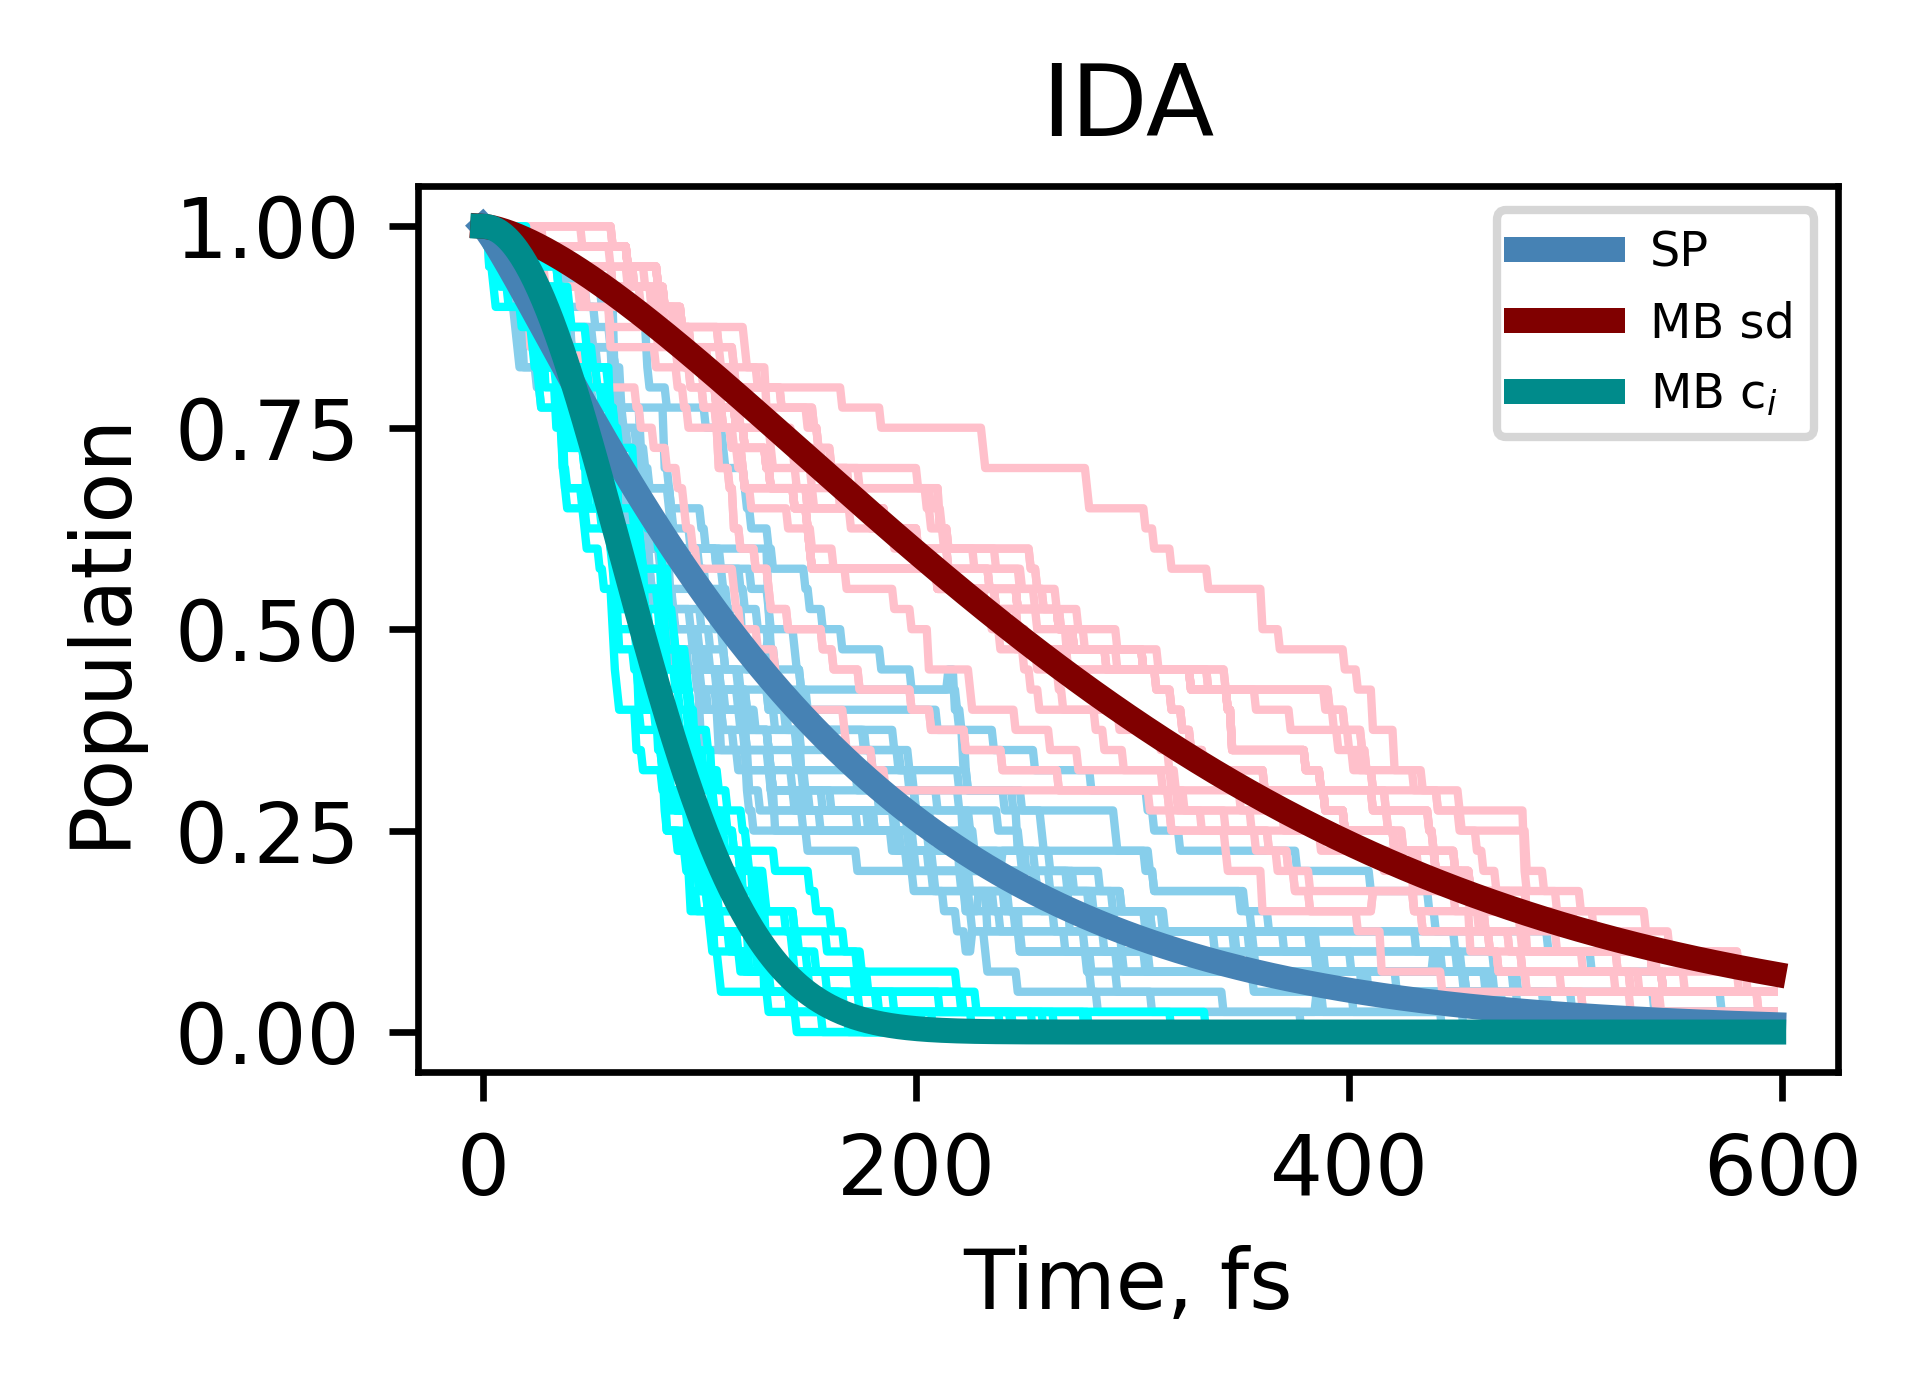

------------mSDM----------
Folder = ./results/namd_regular_sd/_start_s10_mSDM_batch0
tau: 197.87087111045318  beta: 1.137323378296536  R2: 0.9803883816230453
Folder = ./results/namd_regular_sd/_start_s10_mSDM_batch1
tau: 134.3743358611935  beta: 1.4064168457391297  R2: 0.9811694500278623
Folder = ./results/namd_regular_sd/_start_s10_mSDM_batch2
tau: 170.88539822869853  beta: 1.0399684723357232  R2: 0.9632784342354204
Folder = ./results/namd_regular_sd/_start_s10_mSDM_batch3
tau: 109.64235644331013  beta: 1.3614463083569757  R2: 0.973946590561782
Folder = ./results/namd_regular_sd/_start_s10_mSDM_batch4
tau: 146.47205512426933  beta: 1.58718617315626  R2: 0.9944972808539021
Folder = ./results/namd_regular_sd/_start_s10_mSDM_batch5
tau: 127.6910193424802  beta: 0.9433249588357503  R2: 0.9685679575038408
Folder = ./results/namd_regular_sd/_start_s10_mSDM_batch6
tau: 156.18921691148762  beta: 1.2271032295454716  R2: 0.9870608986828531
Folder = ./results/namd_regular_sd/_start_s10_mSDM_batc

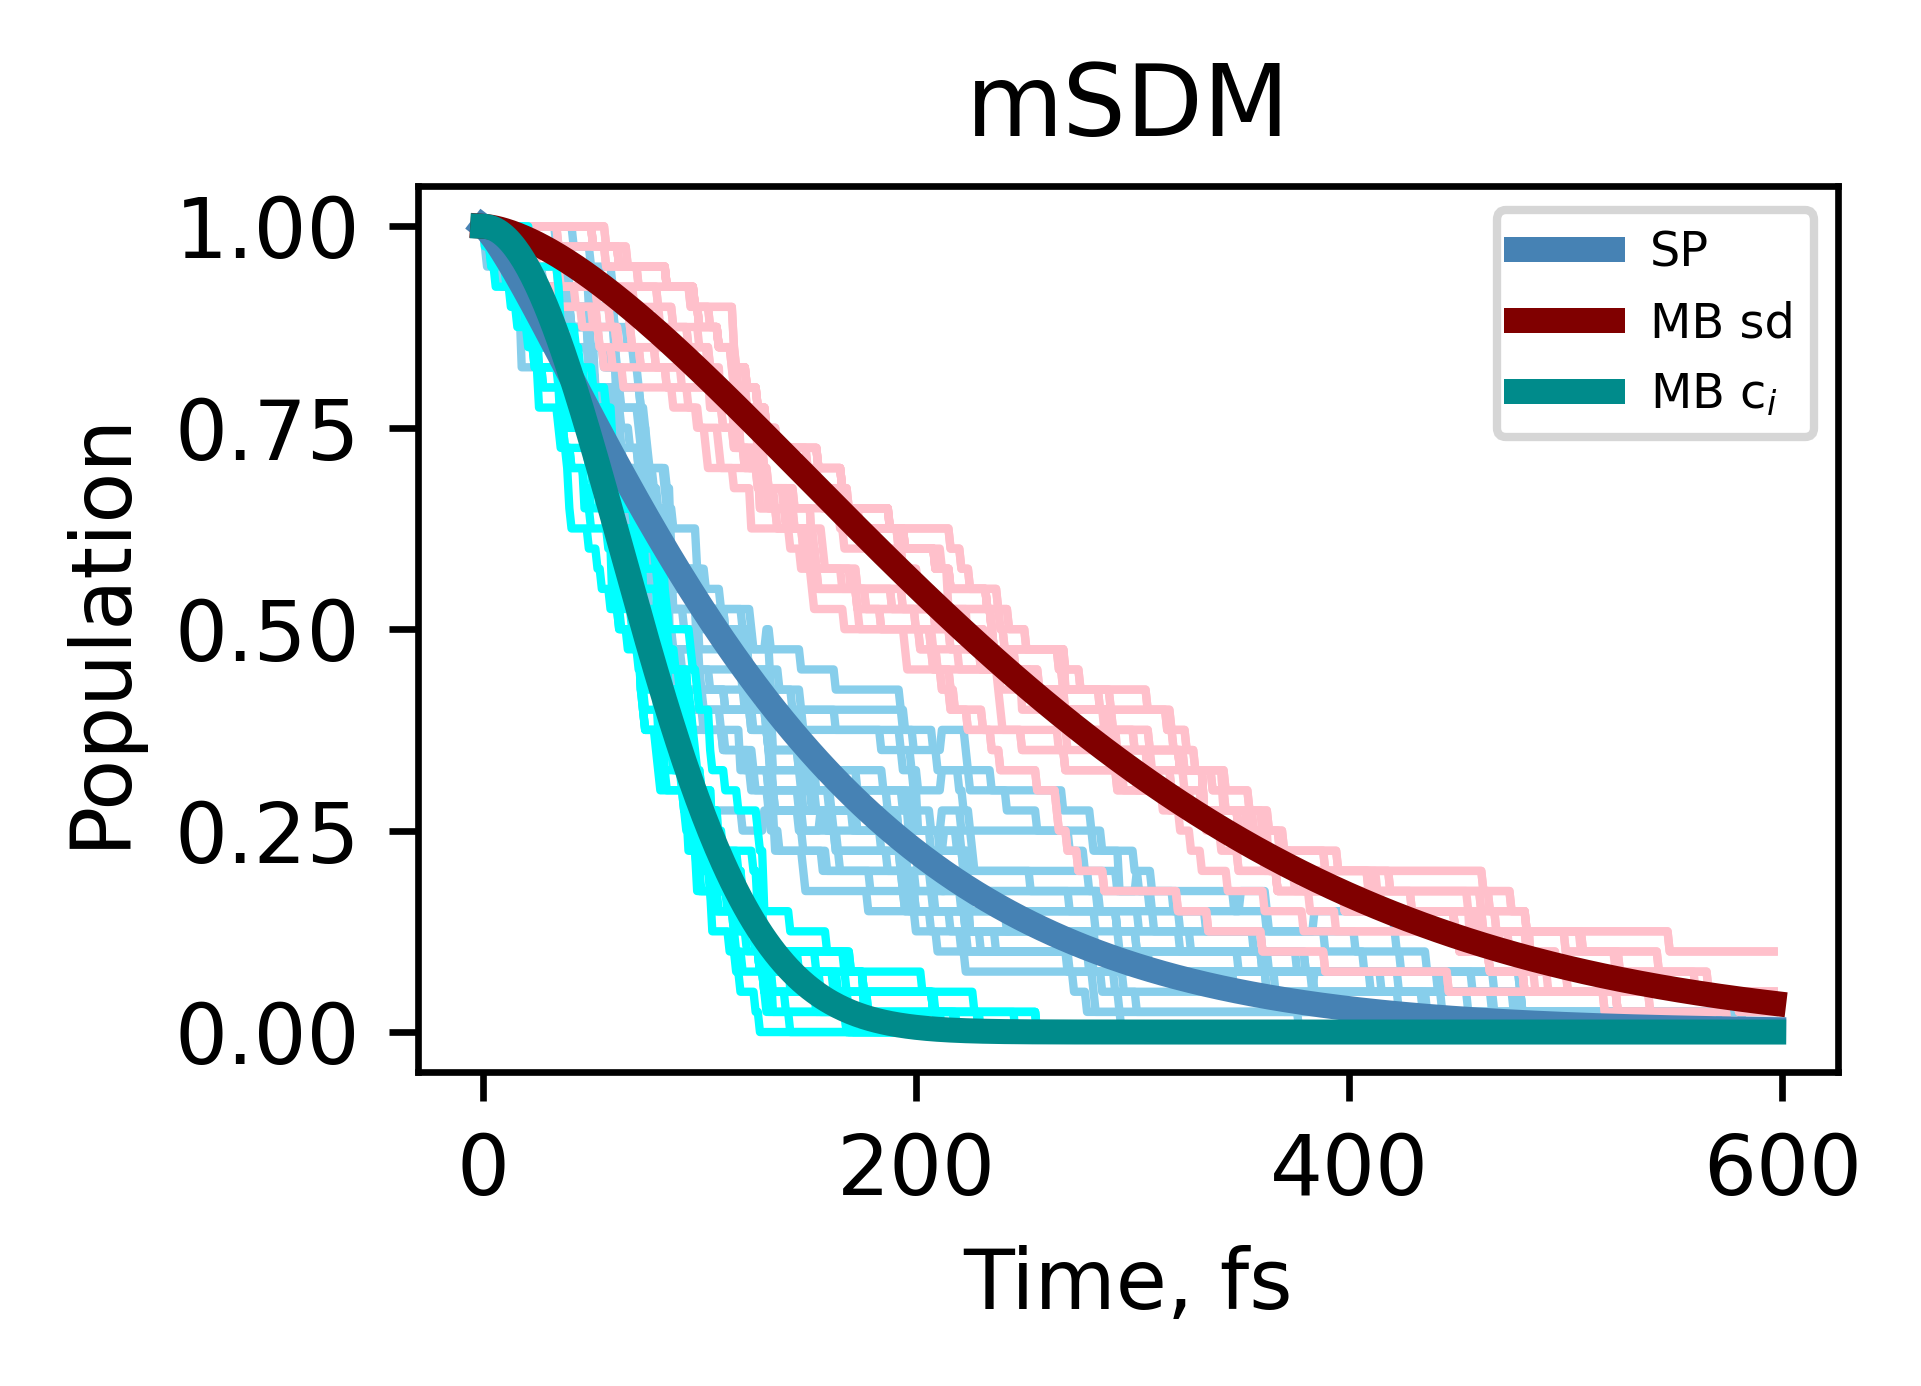

In [12]:
%matplotlib inline
#notebook
#figure = plt.figure(num=None, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)        

def stretched_compressed(t, tau, beta):
    return np.exp( -np.power(( t/tau ),beta) )

for c, scheme in enumerate(['FSSH', 'IDA','mSDM']):
    figure = plt.figure(num=None, figsize=(3.21, 2.41), dpi=600, edgecolor='black', frameon=True)
    print(F'------------{scheme}----------')
    #plt.subplot(1,2,c+1)
    folders = glob.glob(F'./results/namd_regular_sd/_start_s10_{scheme}_batch*', recursive = True)
    taus = []
    betas = []
    
    for folder in folders:
        
        print("Folder =", folder)
        sh_pop = np.loadtxt(folder+'/SH_pop.txt')
        sh_pop_hot_state = sh_pop[:,10]
        md_time = np.arange(0, sh_pop_hot_state.shape[0], 1.0)
        popt, pcov = curve_fit( stretched_compressed, md_time, sh_pop_hot_state, 
                                   bounds=([0.0, 0.0],[np.inf, np.inf]))
        tau, beta = popt
        # Computing the R-squared
        residuals  = sh_pop_hot_state - stretched_compressed(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop_hot_state - np.mean(sh_pop_hot_state))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        print('tau:', tau, ' beta:', beta,' R2:', r_squared)
        
        if r_squared>0.01:
            taus.append(tau)
            betas.append(beta)
            plt.plot(md_time, sh_pop_hot_state,  linewidth=1, color = "skyblue")
            
    ave_tau = np.average(np.array(taus))
    ave_beta = np.average(np.array(betas))
    # Compute the erro bars
    # The confidence interval
    Z = 1.96
    N = len(taus)
    s = np.std(np.array(taus))
    error_bar = Z*s/np.sqrt(N)
    
######################################################################################################################        
    
    
    folders2 = glob.glob(F'./results/namd_regular_mb-Hvib_ci/_start_s10_{scheme}_batch*', recursive = True)
    taus2 = []
    betas2 = []    
    for folder in folders2:
        
        print("Folder =", folder)
        sh_pop = np.loadtxt(folder+'/SH_pop.txt')
        sh_pop_hot_state = sh_pop[:,10]
        md_time2 = np.arange(0, sh_pop_hot_state.shape[0], 1.0)
        popt, pcov = curve_fit( stretched_compressed, md_time, sh_pop_hot_state, 
                                   bounds=([0.0, 0.0],[np.inf, np.inf]))
        tau, beta = popt
        # Computing the R-squared
        residuals  = sh_pop_hot_state - stretched_compressed(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop_hot_state - np.mean(sh_pop_hot_state))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        print('tau:', tau, ' beta:', beta,' R2:', r_squared)
        
        if r_squared>0.01:
            taus2.append(tau)
            betas2.append(beta)
            plt.plot(md_time2, sh_pop_hot_state,  linewidth=1, color = "pink")
            
    ave_tau2 = np.average(np.array(taus2))
    ave_beta2 = np.average(np.array(betas2))
    # Compute the erro bars
    # The confidence interval
    Z = 1.96
    N = len(taus2)
    s = np.std(np.array(taus2))
    error_bar = Z*s/np.sqrt(N)
    
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@2    
     
    folders3 = glob.glob(F'./results//namd_regular_mb-Hvib_sd/_start_s10_{scheme}_batch*', recursive = True)
    taus3 = []
    betas3 = []    
    for folder in folders3:
        
        print("Folder =", folder)
        sh_pop = np.loadtxt(folder+'/SH_pop.txt')
        sh_pop_hot_state = sh_pop[:,10]
        md_time3 = np.arange(0, sh_pop_hot_state.shape[0], 1.0)
        popt, pcov = curve_fit( stretched_compressed, md_time, sh_pop_hot_state, 
                                   bounds=([0.0, 0.0],[np.inf, np.inf]))
        tau, beta = popt
        # Computing the R-squared
        residuals  = sh_pop_hot_state - stretched_compressed(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop_hot_state - np.mean(sh_pop_hot_state))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        print('tau:', tau, ' beta:', beta,' R2:', r_squared)
        
        if r_squared>0.01:
            taus3.append(tau)
            betas3.append(beta)
            plt.plot(md_time3, sh_pop_hot_state,  linewidth=1, color = "aqua")
            
    ave_tau3 = np.average(np.array(taus3))
    ave_beta3 = np.average(np.array(betas3))
    # Compute the erro bars
    # The confidence interval
    Z = 1.96
    N = len(taus3)
    s = np.std(np.array(taus3))
    error_bar = Z*s/np.sqrt(N)
    
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@2    
       
    print(F'The timescales: {ave_tau}+-{error_bar} average over {len(taus)} samples')
    # Plot average fit
    #plt.plot(md_time, stretched_compressed(md_time, ave_tau-error_bar, ave_beta), ls='--',linewidth=3, color='red')
    plt.plot(md_time, stretched_compressed(md_time, ave_tau,           ave_beta), ls='-',  linewidth=3,label='SP', color='steelblue')
    plt.plot(md_time2, stretched_compressed(md_time2, ave_tau2,           ave_beta2), ls='-',  linewidth=3,label='MB sd', color='maroon')
    plt.plot(md_time3, stretched_compressed(md_time3, ave_tau3,           ave_beta3), ls='-',  linewidth=3,label='MB c$_i$', color='darkcyan')

    #plt.plot(md_time, stretched_compressed(md_time, ave_tau+error_bar, ave_beta), ls='--', linewidth=3, color='red')
    plt.legend(fontsize=5.75, ncol=1, loc='upper right')
    plt.title(scheme)
    plt.xlabel('Time, fs')
    plt.ylabel('Population')
    plt.tight_layout()
    plt.savefig(F'./results/{scheme}-SD-sd_mb.png', dpi=600)
    plt.show() 